In [6]:
import cv2
import skimage

import matplotlib.pyplot as plt
import numpy as np

So far our focus has been the regions such as foreground and background. How about the boundary between them, the edges? Edge detection is an effective method for finding regions.

1. What is an edge?
2. Canny edge detection
3. Contours

## 1. What is an edge?

But what is an edge and how can we find it?

Let's go back to the previous example where we plotted the cross section of a coin:

Text(0.5, 0, 'Pixel location on the blue line')

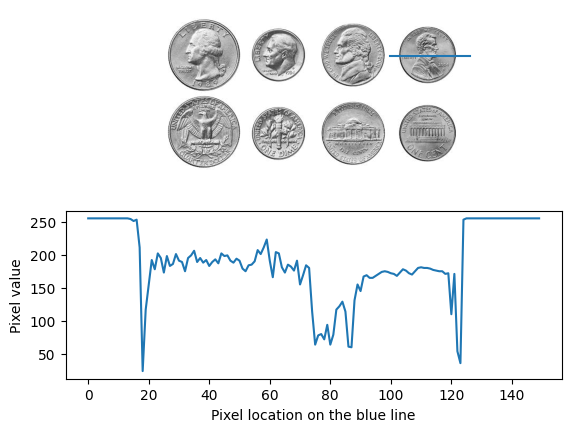

In [12]:
# Let's find a line that cuts the penny in half
im = cv2.imread('images/coins.jpeg', 0)

fig, ax = plt.subplots(2)

ax[0].imshow(im, cmap='gray')
ax[0].plot([450, 600], [88, 88])
ax[0].axis('off')

ax[1].plot(im[88, 450:600])
ax[1].set_ylabel('Pixel value')
ax[1].set_xlabel('Pixel location on the blue line')

Edges are the locations where pixel value changes very abruptly. Whenever you hear change, you should think about the derivate. Positive derivate means pixel value increases (coin to background) and negative derivative means pixel value decreases (background to coin).

Let's approximate the derivative using numpy, find max-min values to detect edges:

Text(0.5, 0, 'Pixel location on the blue line')

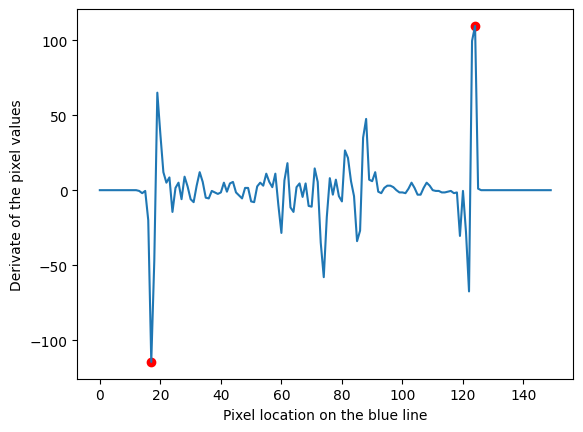

In [13]:
# Approximate gradient
derivative = np.gradient(im[88, 450:600])

# Find min point
y_min = min(derivative)
x_min = np.argmin(derivative)

# Find max point
y_max = max(derivative)
x_max = np.argmax(derivative)

# plot all
plt.plot(derivative)
plt.scatter(x_min, y_min, color='r')
plt.scatter(x_max, y_max, color='r')
plt.ylabel('Derivate of the pixel values')
plt.xlabel('Pixel location on the blue line')

So we answered the questions we asked at the beginning of this section: an edge is a location where pixel value changes abruptly and this can be detected using the derivative.

## 2. Canny edge detection

In 1986, John F. Canny developed an edge detection algorithm based on the idea we described in the previous section. It is one of the most popular edge detection algorithms and it is called Canny edge detector. Please read the following to understand how it works and to understand how to use it with OpenCV:

- [The Wikipedia article](https://en.wikipedia.org/wiki/Canny_edge_detector)
- [The OpenCV documentation](https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html)

`edges = cv2.Canny(image, threshold1, threshold2)`

Parameters:
- image: 8-bit input image.
- threshold1: first threshold for the hysteresis procedure.
- threshold2: second threshold for the hysteresis procedure.

Returns:
- edges: output edge map, a binary image where pixels that belong to an edge has 255 intensity value and 0 otherwise.

Different images will require different thresholds, therefore understanding what they are is indispensable(explained in the OpenCV documentation).


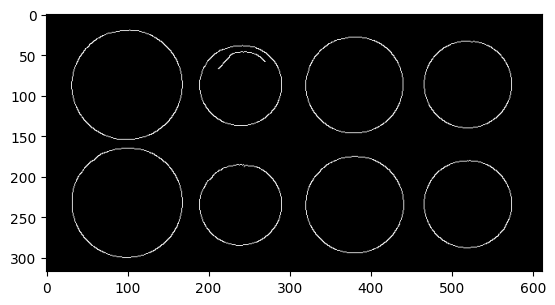

In [44]:
im = cv2.imread('images/coins.jpeg', 0)
im = cv2.GaussianBlur(im, (13, 13), 0)
edges = cv2.Canny(im, threshold1=100, threshold2=240)
plt.imshow(edges, cmap='gray')

Great, we have found all the coin edges! Notice that there is one edge inside a coin which we don't want. This could potentially be removed by blurring parameters or edge detection parameters. We will learn how to deal with it in the next section. 

In [45]:
# Binary image
np.unique(edges)

array([  0, 255], dtype=uint8)

**Exercise 4.1**

Find the edges in the cell image. Expected output:

<img src='images/cell_canny_exercise.png'>

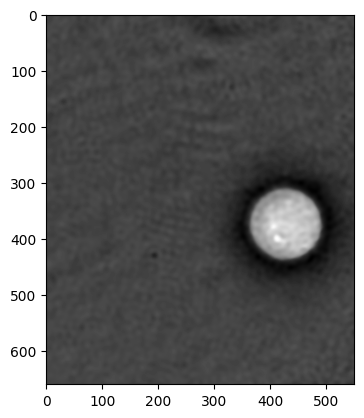

In [61]:
im_cell = skimage.data.cell()
plt.imshow(im_cell, cmap='gray')

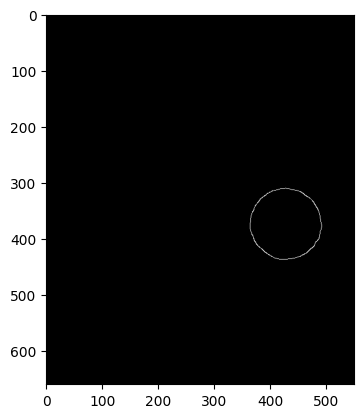

In [62]:
# YOUR CODE HERE
im_cell = cv2.GaussianBlur(im_cell, (11, 11), 0)
edges_1 = cv2.Canny(im_cell, threshold1=0, threshold2=120)
plt.imshow(edges_1, cmap = 'grey')

## 3. Contours

Edge detection tells us if a pixel belongs to an edge, but it does not tell us anything about which edge pixels are connected.

A contour is connected edge pixels. Using OpenCV, we can find contours on the edge image.

Read the following tutorial to understand contours in OpenCV:

https://docs.opencv.org/4.x/d3/d05/tutorial_py_table_of_contents_contours.html

`contours, hierarchy = cv2.findContours(image, mode, method)`

Parameters:

- `image`: 8-bit single channel image, preferable to use a binary image.
- `mode`: Contour retrieval mode, see [RetrievalModes](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#ga819779b9857cc2f8601e6526a3a5bc71)
- `method`: Contour approximation method, see [ContourApproximationModes](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#ga4303f45752694956374734a03c54d5ff)

Returns:

- `contours`: A tuple containing detected contours. Each contour is a numpy array containing the contour points.
- `hierarcy`: Contour Hierarchy

Now let's find contours with `cv2.RETR_LIST` which 'retrieves all of the contours without establishing any hierarchical relationships' and `cv2.CHAIN_APPROX_SIMPLE` which 'compresses horizontal, vertical, and diagonal segments and leaves only their end points'.

In [46]:
contours, hierarchy = cv2.findContours(edges, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)

Most of the time, the output of an operation was an image as well so we could just display it. However `contours` is a tuple with each contour encoded as point coordinates. OpenCV provides `cv2.drawContours()` to draw contours easily. Read the [documentation](https://docs.opencv.org/4.x/d6/d6e/group__imgproc__draw.html#ga746c0625f1781f1ffc9056259103edbc) to understand its parameters.

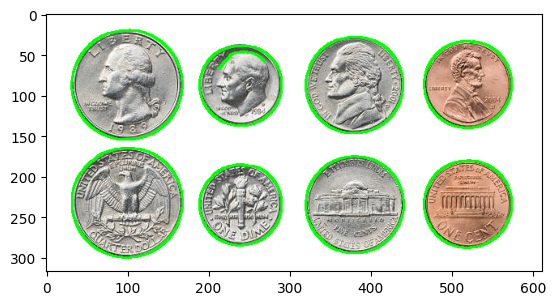

In [57]:
im = cv2.imread('images/coins.jpeg')
im = cv2.drawContours(im, contours, contourIdx=-1, color=(0, 255, 0), thickness=2)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im, cmap='gray')

`contourIdx=-1` draws all the contours. We can select individual contours using their id:

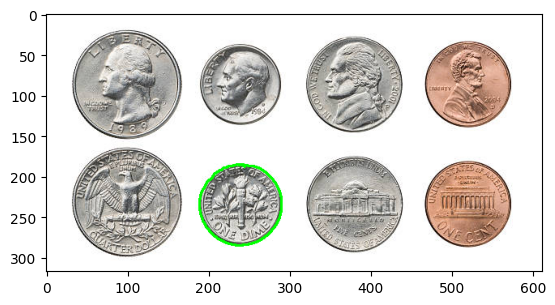

In [58]:
im = cv2.imread('images/coins.jpeg')
im = cv2.drawContours(im, contours, contourIdx=0, color=(0, 255, 0), thickness=2)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im, cmap='gray')

Remember the edge we discussed before that is inside the coin:

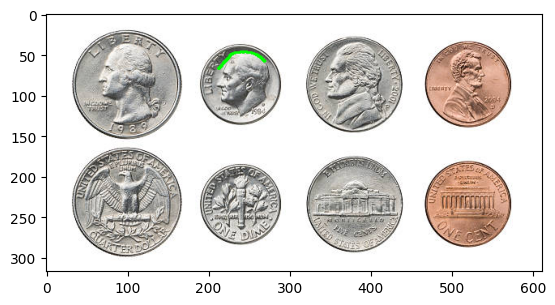

In [59]:
im = cv2.imread('images/coins.jpeg')
im = cv2.drawContours(im, contours, contourIdx=8, color=(0, 255, 0), thickness=2)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im, cmap='gray')

The good thing about converting edges to contours is we can now use contour properties to filter such unwanted contours, using the `mode` parameter. How?

- `cv2.RETR_EXTERNAL` retrieves only the extreme outer contours.

Exactly what we need!

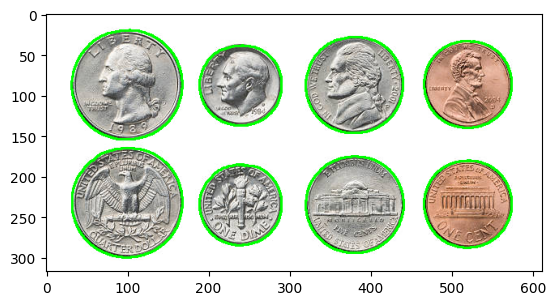

In [60]:
contours, hierarchy = cv2.findContours(edges, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
im = cv2.imread('images/coins.jpeg')
im = cv2.drawContours(im, contours, contourIdx=-1, color=(0, 255, 0), thickness=2)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im, cmap='gray')

and it worked like a charm 💃

**Exercise 4.2**

Using the edges you found in Exercise 4.2, find and plot the contours. Expected output:

<img src='images/cell_contours_exercise.png'>

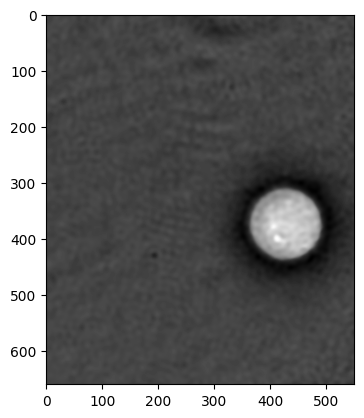

In [63]:
im_cell = skimage.data.cell()
plt.imshow(im_cell, cmap='gray')

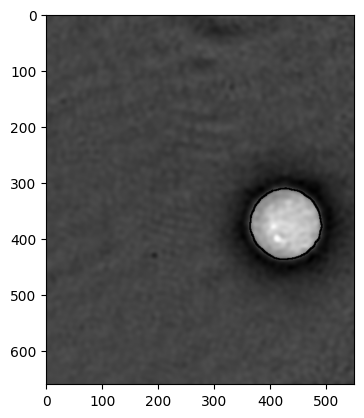

In [65]:
# YOUR CODE HERE
contours, hierarchy = cv2.findContours(edges_1, mode = cv2.RETR_EXTERNAL, method = cv2.CHAIN_APPROX_SIMPLE)
im_cell = cv2.drawContours(im_cell, contours, contourIdx = -1, color = (0, 0, 0), thickness = 2)
im_cell = cv2.cvtColor(im_cell, cv2.COLOR_BGR2RGB)
plt.imshow(im_cell, cmap = 'grey')